# What is a U-Net?
When you ask a computer vision engineer about *image segmentation*, it’s likely that the term U-Net will be mentioned somewhere in their explanation.

The U-Net, which is named after its shape, is a convolutional architecture originally proposed by Ronneberger et al. (2015) for use in the biomedical sciences. More specifically, it is used for cell segmentation, and worked really well compared to approaches previously used in the field.

# U-Nets are composed of three component groups:

1. ***A contracting path***. Visible to the left in the image below, groups of convolutions and pooling layers are used to downsample the image, sometimes even halving it in size. The contracting path learns a hierarchy of features at varying levels of granularity.


2. ***An expansive path***. To the right, you see groups of upsampling layers (whether simple interpolation layers or transposed convolutions) that upsample the resolution of the input image. In other words, from the contracted input, the network tries to construct a higher-resolution output.

3. ***Skip connections***. Besides having the lower-level feature maps as input to the upsampling process, U-Net also receives information from the contracting path’s same-level layer. This is to mitigate the information bottleneck present at the lowest layer in the U, effectively ‘dropping’ the signal from higher-level features if not used through skip connections.

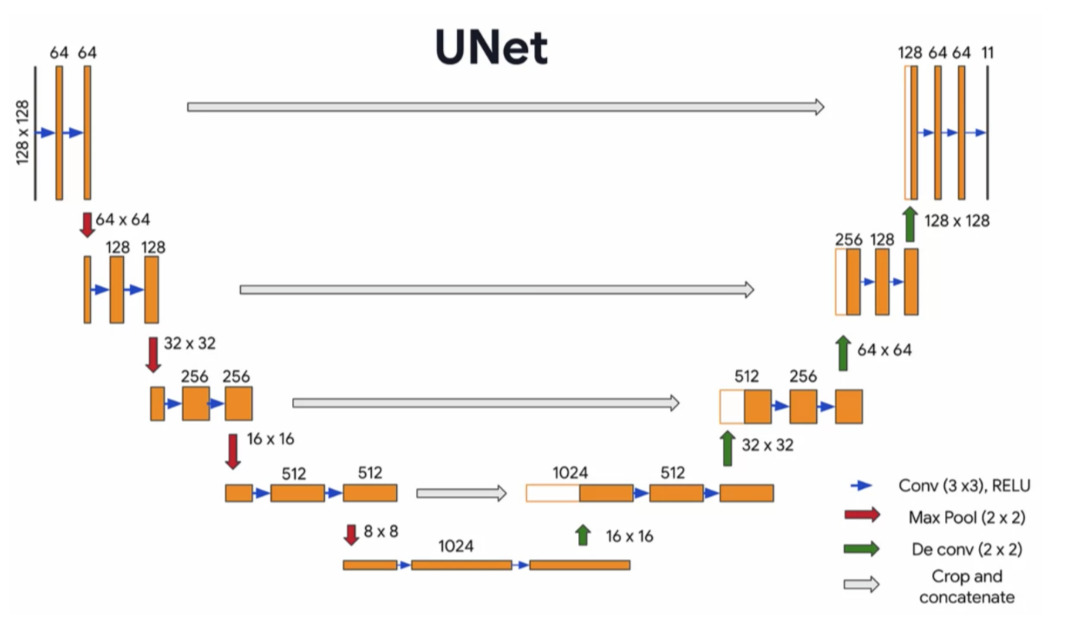

# Code Begins

In [25]:
!pip install tensorflow matplotlib

## Dependencies

In [26]:
import os
import tensorflow
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Input, Activation, Concatenate, CenterCrop
from tensorflow.keras import Model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import schedules, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

**Structure**:

Building a U-Net model can be grouped into three separate tasks, besides specifying model imports:

1. Defining the configuration of your U-Net model, so that it can be reused throughout your code.

2. Defining the building blocks of your U-Net.

3. Defining the process functions to train and evaluate your U-Net model.

## U-Net configuration definition


Here's a simpler explanation of the U-Net configuration parameters with examples:

### 1. **Data Splitting**
- `data_train_prc = 80`: 80% of data is used for training.  
  *Example: If you have 100 images, 80 will be for training.*
- `data_val_prc = 90`: 10% is for validation (from 80% to 90%).  
  *Example: From the remaining 20 images, 10 (90-80) are for validation.*
- `data_test_prc = 100`: 10% is for testing (from 90% to 100%).  
  *Example: The last 10 images are for testing.*

### 2. **U-Net Structure**
- `num_filters_start = 64`: The first layer starts with 64 filters (feature detectors).  
  *Example: Like using 64 small brushes to pick up basic edges/colors in an image.*
- `num_unet_blocks = 3`: The U-Net has 3 down-sampling and 3 up-sampling blocks.  
  *Example: Think of shrinking the image 3 times (down) and then expanding it back 3 times (up).*
- `num_filters_end = 3`: The final output has 3 filters (e.g., for 3 classes like background, object, edge).  
  *Example: The network assigns each pixel to 1 of 3 categories.*

### 3. **Image & Mask Sizes**
- `input_width = 100`, `input_height = 100`: Input images are resized to 100x100 pixels.  
  *Example: All images are adjusted to this size before processing.*
- `mask_width = 60`, `mask_height = 60`: Masks (output labels) are 60x60 pixels.  
  *Example: The network predicts labels for a smaller central region.*

### 4. **Training Setup**
- `batch_size = 50`: 50 images are processed together in one step.  
  *Example: Instead of 1-by-1, the network learns from 50 images at once.*
- `num_epochs = 50`: The entire dataset is passed through the network 50 times.  
  *Example: The network sees all images 50 times to improve slowly.*
- `loss = SparseCategoricalCrossentropy`: Measures how bad the predictions are.  
  *Example: Penalizes wrong pixel classifications (e.g., calling a "cat" pixel "dog").*
- `optimizer = Adam`: Adjusts the model to reduce loss.  
  *Example: Like a smart GPS correcting its route to reach the destination faster.*

### 5. **Learning Rate (How Fast the Model Learns)**
- `lr_schedule_values = [3e-4, 1e-4, 1e-5, 1e-6]`: Learning rates change during training.  
  *Example: Starts fast (0.0003), then slows down (0.000001) to fine-tune.*
- `lr_schedule_percentages = [0.2, 0.5, 0.8]`: Rate changes at 20%, 50%, and 80% of training.  
  *Example: After 10 epochs (20% of 50), the rate drops from 3e-4 to 1e-4.*

### 6. **Class Weights**
- `class_weights = [1.0, 1.0, 2.0]`: Makes the network focus more on class 3 (e.g., rare objects).  
  *Example: If "tumor pixels" are rare, give them double weight to avoid ignoring them.*

### 7. **Others**
- `dataset_path`: Where your images/masks are stored (e.g., `/data` folder).  
- `metrics = ['accuracy']`: Tracks % of correctly predicted pixels.  
- `initializer = HeNormal()`: Sets how initial random weights are chosen (helps training start well).

### **Simple U-Net Workflow Example**
1. **Input**: 100x100 RGB image (3 channels).  
2. **Process**:  
   - Shrink image 3 times (down-sample) while detecting features (64 → more filters).  
   - Expand back 3 times (up-sample) to 60x60 mask.  
3. **Output**: 60x60 mask where each pixel is labeled as 1 of 3 classes.  
4. **Training**:  
   - 50 images per batch, 50 epochs.  
   - Learning rate starts high, drops later.  
   - Mistakes on class 3 (e.g., tumors) are penalized twice as much.

In [27]:
def configuration():
  ''' U-NET CONFIGURATION '''

  return dict(
    data_train_prc = 80,
    data_val_prc = 90,
    data_test_prc = 100,
    num_filters_start = 64,
    num_unet_blocks = 3,
    num_filters_end = 3,
    input_width = 100,
    input_height = 100,
    mask_width = 60,
    mask_height = 60,
    input_dim = 3,
    optimizer = Adam,
    loss = SparseCategoricalCrossentropy,
    initializer = HeNormal(),
    batch_size = 50,
    buffer_size = 50,
    num_epochs = 50,
    metrics = ['accuracy'],
    dataset_path = os.path.join(os.getcwd(), 'data'),
    class_weights = tensorflow.constant([1.0, 1.0, 2.0]),
    validation_sub_splits = 5,
    lr_schedule_percentages = [0.2, 0.5, 0.8],
    lr_schedule_values = [3e-4, 1e-4, 1e-5, 1e-6],
    lr_schedule_class = schedules.PiecewiseConstantDecay
  )

## U-Net building block

Recall that a U-Net is composed of a **contracting path**, which itself is built from **convolutional blocks**, and an **expansive path** built from **upsampling blocks**.

At each individual level (except for the last level in the contractive path, which is connected to the head of the expansive path) the **output** of a convolutional block is connected to an **upsampling block** via a **`skip connection`**.

### The Convolution Block

In [28]:
def conv_block(x, filters, last_block):
  '''
  U-Net convolutional block.
  Used for downsampling in the contracting path.
  '''

  config = configuration()

  # First Conv segment
  x = Conv2D(filters, (3, 3), kernel_initializer=config.get("initializer"))(x)
  x = Activation("relu")(x)

  # Second Conv segment
  x = Conv2D(filters, (3, 3), kernel_initializer=config.get("initializer"))(x)
  x = Activation("relu")(x)

  # Keep Conv output for skip input
  skip_input = x

  # Apply pooling if not last block
  if not last_block:
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

  return x, skip_input

### Contracting path and skip connections

Let’s create another function called `contracting_path`.

In it, you will construct the convolutional block that belong to the contracting path.

Per your code above, these convolutional blocks will **perform feature learning** at their level of hierarchy and subsequently perform max pooling to make the Tensors ready for the next convolutional block.

And you will need to take this into account when creating your contracting path.

This is why you will use the utility function `compute_number_of_filters` to **compute the number of filters** used within each convolutional block.

Given the starting number of 64, that will be 64, 128 and 256 for the 3-block U-Net that you are building

---

This utility function is actually really simple:

you take the number of filters in your first convolutional block (which, per your model configuration is 64) and multiply it with 2^level.

For example, at the third level (with index = 2) your convolutional block has 64 x 2² = 256 filters.

In [29]:
def compute_number_of_filters(block_number):
 '''
  Compute the number of filters for a specific
  U-Net block given its position in the contracting path.
 '''
 return configuration().get("num_filters_start") * (2 ** block_number)

In [30]:
print(compute_number_of_filters(0))

64


In [31]:
config = configuration()
for index in range(config.get("num_unet_blocks")):
  print(index)

0
1
2


In [32]:
num_filters = [compute_number_of_filters(index) for index in range(config.get("num_unet_blocks"))]
print(num_filters)

[64, 128, 256]


In [33]:
def contracting_path(x):
  '''
  U-Net contracting path.
  Initializes multiple convolutional blocks for
  downsampling.
  '''

  config = configuration()

  num_filters = [compute_number_of_filters(index) for index in range(config.get("num_unet_blocks"))]

  skip_inputs = []

  # Pass input x through all convolutional blocks and
  # add skip input Tensor to skip_inputs if not last block
  for index, block_num_filters in enumerate(num_filters):

    last_block = index == len(num_filters) - 1

    x, skip_input = conv_block(x, block_num_filters, last_block)

    if not last_block:
      skip_inputs.append(skip_input)

  return x, skip_inputs

### Visualize Contraction

---

### **Assumptions**
1. **Input**: A single image of size `100x100x3` (width=100, height=100, RGB channels=3).
2. **Configuration** (from `configuration()`):
   - `num_unet_blocks = 3` (3 downsampling blocks).
   - `num_filters_start = 64` (first block starts with 64 filters).

---

### **Step-by-Step Dry Run**

#### **1. Compute Number of Filters for Each Block**
The function `compute_number_of_filters(block_number)` calculates filters for each block as:
- **Block 0**: `64 * (2^0) = 64` filters
- **Block 1**: `64 * (2^1) = 128` filters  
- **Block 2**: `64 * (2^2) = 256` filters  

So, `num_filters = [64, 128, 256]`.

---

#### **2. Contracting Path Execution**
We process the input through 3 blocks:

##### **Block 0 (First Block)**
- **Input**: `x` = `(100, 100, 3)` (original image).
- **Operations**:
  1. **First Conv2D**: Applies 64 filters of size `3x3` → Output shape: `(100, 100, 64)`.
  2. **ReLU Activation**: No shape change.
  3. **Second Conv2D**: Another `3x3` conv with 64 filters → Output shape: `(100, 100, 64)`.
  4. **ReLU Activation**: No shape change.
- **Skip Connection**: Saves this output (`skip_input = (100, 100, 64)`) for later.
- **MaxPooling**: Since this is **not the last block**, we downsample with `MaxPool2D(strides=2)` → Output shape: `(50, 50, 64)`.
- **Result**: `x` is now `(50, 50, 64)` (passed to next block).

##### **Block 1 (Second Block)**
- **Input**: `x` = `(50, 50, 64)`.
- **Operations**:
  1. **First Conv2D**: 128 filters → Output shape: `(50, 50, 128)`.
  2. **ReLU Activation**: No change.
  3. **Second Conv2D**: Another `3x3` conv → Output shape: `(50, 50, 128)`.
  4. **ReLU Activation**: No change.
- **Skip Connection**: Saves `(50, 50, 128)`.
- **MaxPooling**: Downsamples again → Output shape: `(25, 25, 128)`.
- **Result**: `x` is now `(25, 25, 128)`.

##### **Block 2 (Last Block)**
- **Input**: `x` = `(25, 25, 128)`.
- **Operations**:
  1. **First Conv2D**: 256 filters → Output shape: `(25, 25, 256)`.
  2. **ReLU Activation**: No change.
  3. **Second Conv2D**: Another `3x3` conv → Output shape: `(25, 25, 256)`.
  4. **ReLU Activation**: No change.
- **Skip Connection**: **Not saved** (because `last_block = True`).
- **MaxPooling**: **Not applied** (because it’s the last block).
- **Result**: Final `x` = `(25, 25, 256)`.

---

#### **3. Outputs of Contracting Path**
- **Final `x`**: `(25, 25, 256)` (bottleneck features, passed to expanding path).
- **Skip Inputs**:
  - `skip_inputs[0]` = `(100, 100, 64)` (from Block 0).
  - `skip_inputs[1]` = `(50, 50, 128)` (from Block 1).

---

### **Key Takeaways**
1. **Filter Growth**: Each block doubles the filters (`64 → 128 → 256`).
2. **Downsampling**: Image shrinks by half each time (`100x100 → 50x50 → 25x25`).
3. **Skip Connections**: Saves intermediate outputs to help the expanding path (U-Net’s key idea).
4. **Last Block**: No pooling (we’ve reached the bottleneck).

---

### **Visualization**
```
Input (100x100x3)
  │
  ▼
[CONV 3x3, 64] → [ReLU] → [CONV 3x3, 64] → Skip → MaxPool → (50x50x64)
  │
  ▼
[CONV 3x3, 128] → [ReLU] → [CONV 3x3, 128] → Skip → MaxPool → (25x25x128)
  │
  ▼
[CONV 3x3, 256] → [ReLU] → [CONV 3x3, 256] → (25x25x256)  [Bottleneck!]
```
*(Skip connections are saved for the expanding path.)*

---

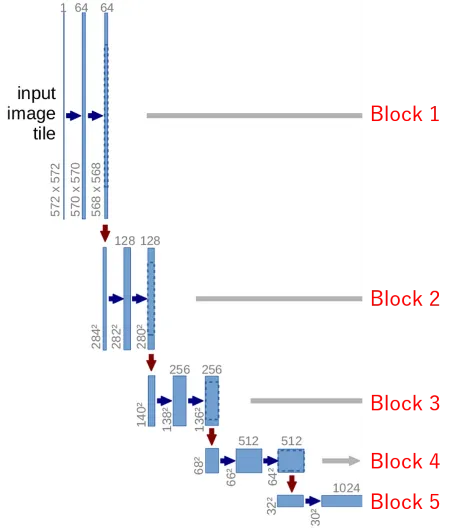

### The upsampling block

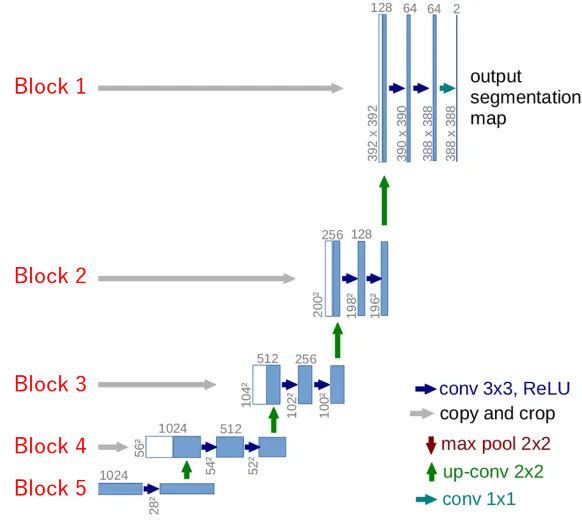

It’s time to discuss the following important detail — **the crop that is applied to the skip connection**

Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that

1. halves the number of feature channels,

2. a concatenation with the correspondingly cropped feature map from the contracting path, and
3. two 3x3 convolutions, each followed by a ReLU.

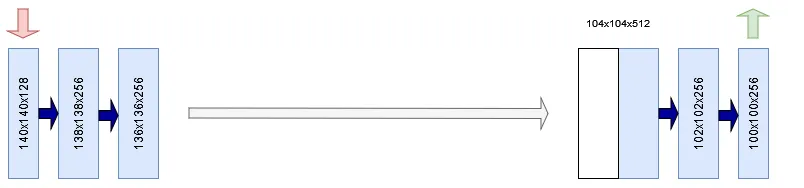

To make this crop, you use TensorFlow’s `CenterCrop` layer to take a center crop from the skip input using the target width and height as specified by the upsampled Tensor.

Then, you use the `Concatenate` layer to concatenate the cropped skip input with the upsampled Tensor, after which you can **proceed with processing the whole**.

---

Finally, at the last layer, you apply an 1x1 convolution (preserving the width and height dimensions) that outputs a Tensor with C for the third dimension.

C, here, represents the desired number of classes — something we have in our model configuration as `num_filters_end`, and, indeed, that is three classes for today's dataset! :)

In [34]:
def upconv_block(x, filters, skip_input, last_block=False):
  '''
  U-Net upsampling block.
  Used for upsampling in the expansive path.
  '''

  config = configuration()

  # Perform upsampling
  x = Conv2DTranspose(filters//2, (2, 2), strides=(2, 2), kernel_initializer=config.get("initializer"))(x)
  shp = x.shape

  # Crop the skip input, keep the center
  cropped_skip_input = CenterCrop(height=x.shape[1], width=x.shape[2])(skip_input)

  # Concatenate skip input with x
  concat_input = Concatenate(axis=-1)([cropped_skip_input, x])

  # First Conv segment
  x = Conv2D(filters//2, (3, 3), kernel_initializer=config.get("initializer"))(concat_input)
  x = Activation("relu")(x)

  # Second Conv segment
  x = Conv2D(filters//2, (3, 3), kernel_initializer=config.get("initializer"))(x)
  x = Activation("relu")(x)

  # Prepare output if last block
  if last_block:
    x = Conv2D(config.get("num_filters_end"), (1, 1), kernel_initializer=config.get("initializer"))(x)

  return x

### Expansive path using skip connections

As with the contracting path, you will also need to compose the upsampling layers in your expansive path.

Similarly to the contracting path, you will also compute the number of filters for the blocks in your expansive path. This time, however, you start counting at the end — i.e., at the number of blocks minus one, because you are working down from a high number of filters to a low number of filters.

Then, you iterate over the number of filters, compute whether it’s the last block and compute the ***level*** to take the skip input from, and pass the Tensor through your upsampling block.

In [35]:
num_filters = [compute_number_of_filters(index) for index in range(configuration().get("num_unet_blocks")-1, 0, -1)]

In [36]:
num_filters

[256, 128]

In [37]:
def expansive_path(x, skip_inputs):
 '''
  U-Net expansive path.
  Initializes multiple upsampling blocks for upsampling.
 '''
 num_filters = [compute_number_of_filters(index) for index in range(configuration().get("num_unet_blocks")-1, 0, -1)]

 skip_max_index = len(skip_inputs) - 1

 for index, block_num_filters in enumerate(num_filters):
  skip_index = skip_max_index - index

  last_block = index == len(num_filters)-1

  x = upconv_block(x, block_num_filters, skip_inputs[skip_index], last_block)

 return x

### Visualize Expansion


## 🧠 Recap of Where We Left Off

From the **contracting path**, we had:

- Final `x` (bottleneck features): `(25, 25, 256)`
- Skip connections:
  - `skip_inputs[0]`: `(100, 100, 64)` from Block 0  
  - `skip_inputs[1]`: `(50, 50, 128)` from Block 1  

---

## ⚙️ Configuration Used
```python
num_unet_blocks = 3
num_filters_start = 64
num_filters_end = 3
```

So:
- Filters in reverse order:  
  `num_filters = [64*(2^2), 64*(2^1)] = [256, 128]`
- We’ll do **(num_unet_blocks - 1) = 2** upsampling blocks

---

## 🔁 Step-by-Step Expanding Path Dry Run

### 🔼 **Upsampling Block 0**
- **Input `x`**: `(25, 25, 256)` (bottleneck features)
- **Skip Input**: `skip_inputs[1] = (50, 50, 128)`
- **Filters**: `block_num_filters = 256`
- **Last Block?**: No

---

#### 🧱 Inside `upconv_block(x, 256, skip_input, last_block=False)`

**1. Conv2DTranspose (upsampling):**
- Filters = `256 // 2 = 128`
- Output shape: `(50, 50, 128)`

**2. CenterCrop skip input:**  
- Already shape `(50, 50, 128)` → no change

**3. Concatenate**:
- x: `(50, 50, 128)`
- skip: `(50, 50, 128)`  
→ After concat: `(50, 50, 256)`

**4. Conv2D (128 filters)** → `(50, 50, 128)`  
**5. ReLU**  
**6. Conv2D (128 filters)** → `(50, 50, 128)`  
**7. ReLU**

---

🔁 Final `x` after block 0 = `(50, 50, 128)`

---

### 🔼 **Upsampling Block 1 (Last Block)**
- **Input `x`**: `(50, 50, 128)`
- **Skip Input**: `skip_inputs[0] = (100, 100, 64)`
- **Filters**: `block_num_filters = 128`
- **Last Block?**: ✅ Yes

---

#### 🧱 Inside `upconv_block(x, 128, skip_input, last_block=True)`

**1. Conv2DTranspose**:  
- Filters = `128 // 2 = 64`  
- Output shape: `(100, 100, 64)`

**2. CenterCrop skip input:**  
- Already `(100, 100, 64)` → no change

**3. Concatenate**:  
- x: `(100, 100, 64)`  
- skip: `(100, 100, 64)`  
→ After concat: `(100, 100, 128)`

**4. Conv2D (64 filters)** → `(100, 100, 64)`  
**5. ReLU**  
**6. Conv2D (64 filters)** → `(100, 100, 64)`  
**7. ReLU**

✅ **8. Final Conv2D (1×1, 3 filters)** (since `num_filters_end = 3`)  
→ Output shape: **`(100, 100, 3)`** — **Final segmentation mask**

---

## ✅ Final Output of Expanding Path

- Shape: `(100, 100, 3)`
- This is a **pixel-wise classification mask** (e.g., 3 classes per pixel)

---

## 🔁 Full Visualization (Expansion)

```
Input to Expanding Path: (25x25x256) ← Bottleneck
  │
  ▼
[TransposedConv 128] → (50x50x128)
  + Skip(50x50x128) → Concat → (50x50x256)
  → Conv(128) + ReLU → Conv(128) + ReLU → (50x50x128)
  │
  ▼
[TransposedConv 64] → (100x100x64)
  + Skip(100x100x64) → Concat → (100x100x128)
  → Conv(64) + ReLU → Conv(64) + ReLU → (100x100x64)
  → Final Conv1x1(3) → **(100x100x3)**
```

### U-Net builder

In [38]:
def build_unet():

  config = configuration()

  input_shape = (config.get("input_height"), config.get("input_width"), config.get("input_dim"))

  #input layer
  input_data = Input(shape=input_shape)

  #contracting path
  contracted_data, skip_inputs = contracting_path(input_data)

  #expansive path
  expanded_data = expansive_path(contracted_data, skip_inputs)

  #model
  model = Model(input_data, expanded_data, name="U-Net")

  return model

In [39]:
model = build_unet()

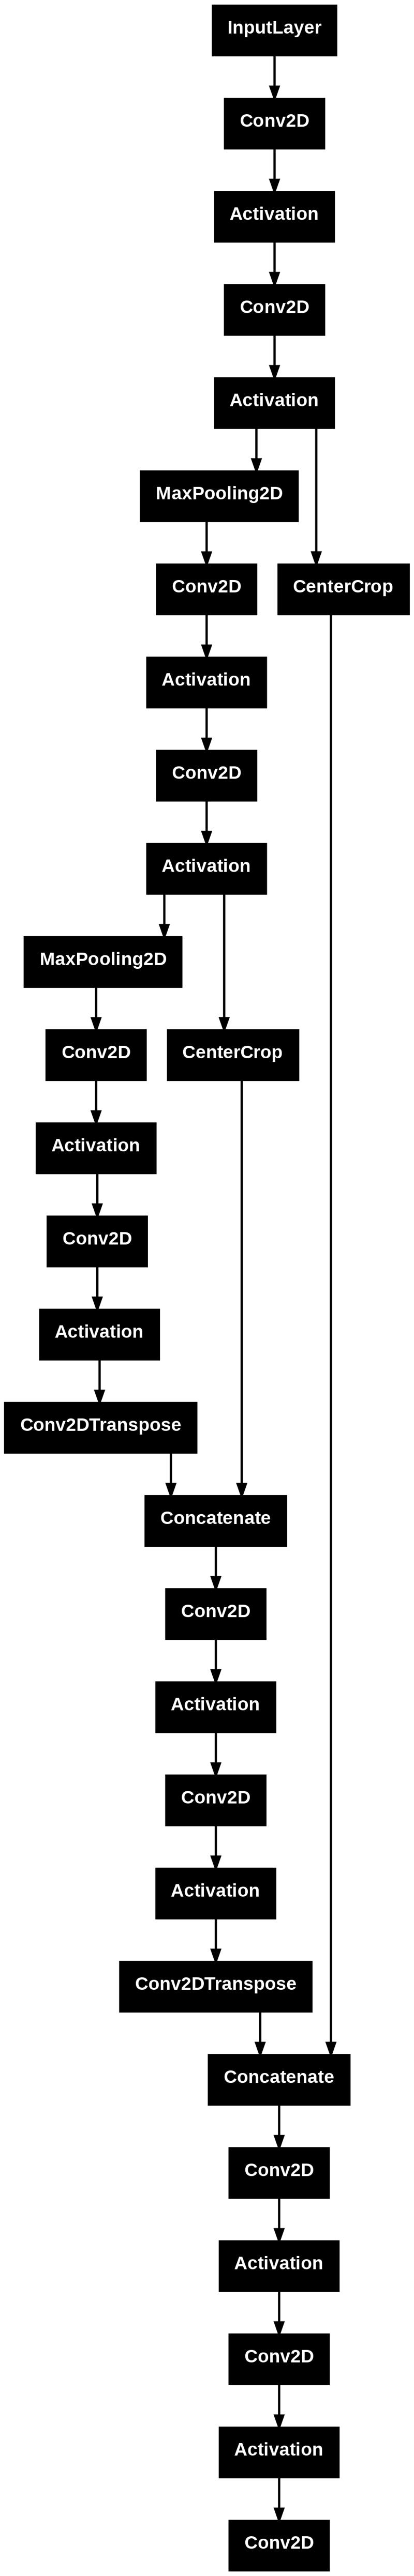

In [40]:
plot_model(model)

### U-Net training process functions

- Initializing the model.
- Loading the dataset.
- Data preprocessing.
- Training callbacks.
- Data visualization.

In [41]:
def init_model(steps_per_epoch):
  '''
  Initialize a U-Net model.
  '''
  config = configuration()
  model = build_unet()

  # Retrieve compilation input
  loss_init = config.get("loss")(from_logits=True)
  metrics = config.get("metrics")
  num_epochs = config.get("num_epochs")

  # Construct LR schedule
  boundaries = [int(num_epochs * percentage * steps_per_epoch) for percentage in config.get("lr_schedule_percentages")]

  lr_schedule = config.get("lr_schedule_class")(boundaries, config.get("lr_schedule_values"))

  # Init optimizer
  optimizer_init = config.get("optimizer")(learning_rate = lr_schedule)

  # Compile the model
  model.compile(loss=loss_init, optimizer=optimizer_init, metrics=metrics)

  # Plot the model
  plot_model(model, to_file="unet.png")

  # Print model summary
  model.summary()

  return model

In [42]:
def load_dataset():
  ''' Return dataset with info. '''
  config = configuration()

  # Retrieve percentages
  train = config.get("data_train_prc")
  val = config.get("data_val_prc")
  test = config.get("data_test_prc")

  # Redefine splits over full dataset
  splits = [f'train[:{train}%]+test[:{train}%]', f'train[{train}%:{val}%]+test[{train}%:{val}%]', f'train[{val}%:{test}%]+test[{val}%:{test}%]']

  # Return data
  return tfds.load('oxford_iiit_pet', split=splits, data_dir=configuration().get("dataset_path"), with_info=True)

In [43]:
def normalize_sample(input_image, input_mask):
  ''' Normalize input image and mask class. '''
  input_image = tensorflow.cast(input_image, tensorflow.float32) / 255.0

  # Bring classes into range [0, 2]
  input_mask -= 1

  return input_image, input_mask

In [44]:
def preprocess_sample(data_sample):
  ''' Resize and normalize dataset samples. '''
  config = configuration()

  # Resize image
  input_image = tensorflow.image.resize(data_sample['image'], (config.get("input_width"), config.get("input_height")))

  # Resize mask
  input_mask = tensorflow.image.resize(data_sample['segmentation_mask'], (config.get("mask_width"), config.get("mask_height")))

  # Normalize input image and mask
  input_image, input_mask = normalize_sample(input_image, input_mask)

  return input_image, input_mask

In [45]:
def data_augmentation(inputs, labels):
  ''' Perform data augmentation. '''
  # Use the same seed for deterministic randomness over both inputs and labels.
  seed = 36

  # Feed data through layers
  inputs = tensorflow.image.random_flip_left_right(inputs, seed=seed)
  inputs = tensorflow.image.random_flip_up_down(inputs, seed=seed)
  labels = tensorflow.image.random_flip_left_right(labels, seed=seed)
  labels = tensorflow.image.random_flip_up_down(labels, seed=seed)

  return inputs, labels

## 🧠 What is a **Mask**?

In semantic segmentation, a **mask** is like a label image — but instead of saying “this image is a cat,” it **tells you what class every pixel belongs to**.

Think of it as:
- Original image: a photo of a pet (e.g., a cat)
- **Mask**: a grayscale image where each pixel has a class ID:
  - `0` for background  
  - `1` for pet  
  - `2` for pet border

Example:

| Original Image       | Corresponding Mask        |
|----------------------|----------------------------|
| ![Cat photo]         | ![Grayscale mask]          |
| Pixels = RGB values  | Pixels = class IDs (0,1,2) |

In code, the **mask** is just a 2D tensor like:

```python
[
 [0, 0, 0, 0],
 [0, 1, 1, 0],
 [0, 1, 1, 0],
 [0, 0, 0, 0],
]
```

---

## 🗂️ What Does the Dataset Look Like?

You're using `tfds.load('oxford_iiit_pet', ...)`. TensorFlow Datasets handles the heavy lifting.

For each sample, you get a dictionary like this:

```python
{
  'image': <Tensor: shape=(H, W, 3), dtype=uint8>,  # the RGB pet image
  'segmentation_mask': <Tensor: shape=(H, W, 1), dtype=int64>  # pixel-wise labels
}
```

Each pair: `(image, mask)` — is one training example.

---

## 🧪 How U-Net Trains and Predicts

U-Net is a **fully convolutional neural network** that:

1. **Takes the input image** (e.g., 128x128x3).
2. Passes it through an **encoder** that downsamples it (extracts features).
3. Then through a **decoder** that upsamples it back to the original size.
4. **Outputs a mask** — same size as input — but each pixel contains **class probabilities**.

### 🔁 Training Steps:

1. `image` is input to U-Net.
2. U-Net outputs a **predicted mask**: a `(H, W, C)` tensor, where C = number of classes.
3. Ground truth `mask` is used to compute loss (like sparse categorical crossentropy).
4. You may use **sample weights** (like your function does) to prioritize learning on specific pixels.
5. Model updates weights via backpropagation.

---

## ✅ U-Net Output Example:

Say your input image is `128x128x3`.

The U-Net outputs:  
`128x128x3` — where 3 is the number of classes (`background`, `pet`, `border`)

For a single pixel, the output might look like:

```python
[0.85, 0.10, 0.05]  # 85% background, 10% pet, 5% border
```

The model predicts the class with the highest probability at each pixel.

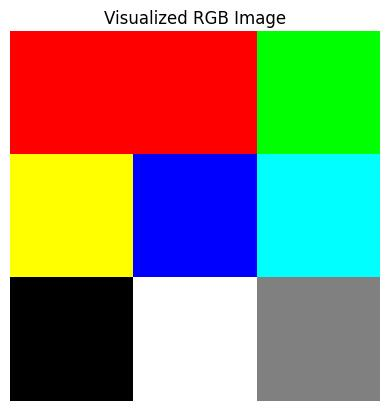

In [46]:
import matplotlib.pyplot as plt
import tensorflow as tf

image = tf.constant([
  [[255, 0, 0],    [255, 0, 0],    [0, 255, 0]],
  [[255, 255, 0],  [0, 0, 255],    [0, 255, 255]],
  [[0, 0, 0],      [255, 255, 255],[128, 128, 128]]
], dtype=tf.int32)

plt.imshow(image.numpy())
plt.title("Visualized RGB Image")
plt.axis('off')
plt.show()

In [47]:
mask = tf.constant([
  [0, 0, 1],
  [1, 2, 2],
  [0, 0, 1]
], dtype=tf.int32)

In [48]:
class_weights = tf.constant([0.1, 0.3, 0.6])

In [49]:
#Resize & Normalize
image = tf.cast(image, tf.float32) / 255.0

Now pixel values are in `[0, 1]`.

In [50]:
#Compute Sample Weights
weights = tf.gather(class_weights, indices=mask)

Each pixel in `mask` is replaced by corresponding weight

In [51]:
weights

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.1, 0.1, 0.3],
       [0.3, 0.6, 0.6],
       [0.1, 0.1, 0.3]], dtype=float32)>

In [52]:
# Example

predicted_mask = tf.constant([
  [[0.9, 0.05, 0.05], [0.8, 0.1, 0.1], [0.1, 0.8, 0.1]],
  [[0.1, 0.7, 0.2], [0.1, 0.1, 0.8], [0.05, 0.2, 0.75]],
  [[0.7, 0.2, 0.1], [0.8, 0.15, 0.05], [0.2, 0.6, 0.2]]
])

Each pixel has a softmax probability over 3 classes.

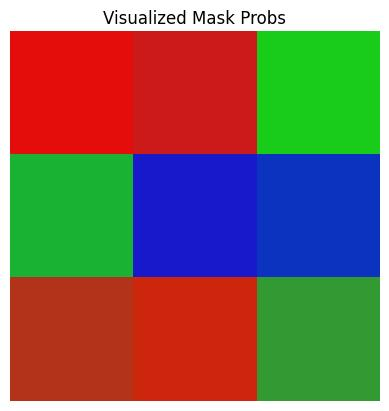

In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf

predicted_mask = tf.constant([
  [[0.9, 0.05, 0.05], [0.8, 0.1, 0.1], [0.1, 0.8, 0.1]],
  [[0.1, 0.7, 0.2], [0.1, 0.1, 0.8], [0.05, 0.2, 0.75]],
  [[0.7, 0.2, 0.1], [0.8, 0.15, 0.05], [0.2, 0.6, 0.2]]
])

plt.imshow(predicted_mask.numpy())
plt.title("Visualized Mask Probs")
plt.axis('off')
plt.show()


Improves over TRAINING

In [54]:
# To convert to a single channel class map (like a mask) from probabilities
final_mask = tf.argmax(predicted_mask, axis=-1)
final_mask

<tf.Tensor: shape=(3, 3), dtype=int64, numpy=
array([[0, 0, 1],
       [1, 2, 2],
       [0, 0, 1]])>

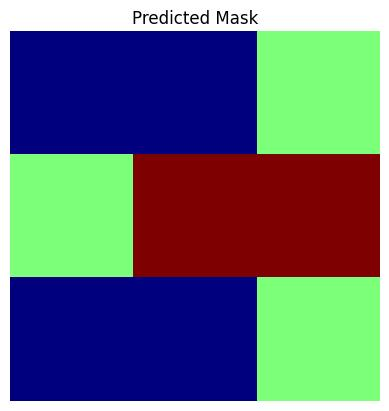

In [55]:
plt.imshow(tf.argmax(predicted_mask, axis=-1).numpy(), cmap="jet")
plt.title("Predicted Mask")
plt.axis('off')
plt.show()

In [56]:
def compute_sample_weights(image, mask):
  ''' Compute sample weights for the image given class. '''

  # Compute relative weight of class
  class_weights = configuration().get("class_weights")
  class_weights = class_weights/tensorflow.reduce_sum(class_weights)

  # Compute same-shaped Tensor as mask with sample weights per mask element.
  sample_weights = tensorflow.gather(class_weights,indices=tensorflow.cast(mask, tensorflow.int32))

  return image, mask, sample_weights

In [57]:
def preprocess_dataset(data, dataset_type, dataset_info):
 ''' Fully preprocess dataset given dataset type. '''
 config = configuration()
 batch_size = config.get("batch_size")
 buffer_size = config.get("buffer_size")

 # Preprocess data given dataset type.
 if dataset_type == "train" or dataset_type == "val":
  # 1. Perform preprocessing
  # 2. Cache dataset for improved performance
  # 3. Shuffle dataset
  # 4. Generate batches
  # 5. Repeat
  # 6. Perform data augmentation
  # 7. Add sample weights
  # 8. Prefetch new data before it being necessary.
  return (data
        .map(preprocess_sample)
        .cache()
        .shuffle(buffer_size)
        .batch(batch_size)
        .repeat()
        .map(data_augmentation)
        .map(compute_sample_weights)
        .prefetch(buffer_size=tensorflow.data.AUTOTUNE))
 else:
  # 1. Perform preprocessing
  # 2. Generate batches
  return (data
      .map(preprocess_sample)
      .batch(batch_size))

In [58]:
def training_callbacks():
 ''' Retrieve initialized callbacks for model.fit '''

 return [
  TensorBoard(
    log_dir=os.path.join(os.getcwd(), "unet_logs"),
    histogram_freq=1,
    write_images=True
  )
 ]

In [59]:
def probs_to_mask(probs):
 ''' Convert Softmax output into mask. '''

 pred_mask = tensorflow.argmax(probs, axis=2)
 return pred_mask

In [60]:
def generate_plot(img_input, mask_truth, mask_probs):
  ''' Generate a plot of input, truthy mask and probability mask. '''
  fig, axs = plt.subplots(1, 4)
  fig.set_size_inches(16, 6)

  # Plot the input image
  axs[0].imshow(img_input)
  axs[0].set_title("Input image")

  # Plot the truthy mask
  axs[1].imshow(mask_truth)
  axs[1].set_title("True mask")

  # Plot the predicted mask
  predicted_mask = probs_to_mask(mask_probs)
  axs[2].imshow(predicted_mask)
  axs[2].set_title("Predicted mask")

  # Plot the overlay
  config = configuration()
  img_input_resized = tensorflow.image.resize(img_input, (config.get("mask_width"), config.get("mask_height")))
  axs[3].imshow(img_input_resized)
  axs[3].imshow(predicted_mask, alpha=0.5)
  axs[3].set_title("Overlay")

  # Show the plot
  plt.show()

### Training Initiation

In [61]:
# Load config
config = configuration()
batch_size = config.get("batch_size")
validation_sub_splits = config.get("validation_sub_splits")
num_epochs = config.get("num_epochs")

In [62]:
# Load data
(training_data, validation_data, testing_data), info = load_dataset()

# Make training data ready for model.fit and model.evaluate
train_batches = preprocess_dataset(training_data, "train", info)
val_batches = preprocess_dataset(validation_data, "val", info)
test_batches = preprocess_dataset(testing_data, "test", info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/data/oxford_iiit_pet/incomplete.LNWRXA_4.0.0/oxford_iiit_pet-train.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/data/oxford_iiit_pet/incomplete.LNWRXA_4.0.0/oxford_iiit_pet-test.tfrecord*...:   0%|      …

Dataset oxford_iiit_pet downloaded and prepared to /content/data/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


Image shape: (100, 100, 3)
Mask shape: (60, 60, 1)


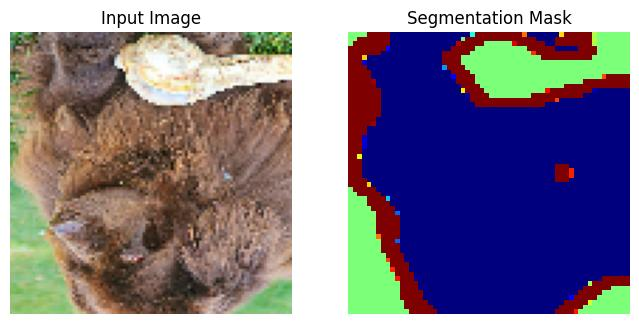

In [73]:
for sample in train_batches.take(1):
    if len(sample) == 3:
        image_batch, mask_batch, weight_batch = sample
    else:
        image_batch, mask_batch = sample

    # Use the first image and mask from the batch
    image = image_batch[0]
    mask = mask_batch[0]

    print("Image shape:", image.shape)  # e.g., (128, 128, 3)
    print("Mask shape:", mask.shape)    # e.g., (128, 128, 1) or (128, 128)

    # Visualize
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(mask).numpy(), cmap="jet")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.show()

In [ ]:
# Compute data-dependent variables
train_num_samples = tensorflow.data.experimental.cardinality(training_data).numpy()
val_num_samples = tensorflow.data.experimental.cardinality(validation_data).numpy()
steps_per_epoch = train_num_samples // batch_size
val_steps_per_epoch = val_num_samples // batch_size // validation_sub_splits

# Initialize model
model = init_model(steps_per_epoch)

# Train the model
model.fit(
  train_batches,
  epochs=num_epochs,
  batch_size=batch_size,
  steps_per_epoch=steps_per_epoch,
  verbose=1,
  validation_steps=val_steps_per_epoch,
  callbacks=training_callbacks(),
  validation_data=val_batches
)

# Test the model
score = model.evaluate(test_batches, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 98, 98,    │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 98, 98,    │          0 │ conv2d_22[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 96, 96,    │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 96, 96,    │          0 │ conv2d_23[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 48, 48,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 46, 46,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 46, 46,    │          0 │ conv2d_24[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 44, 44,    │    147,584 │ activation_22[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 44, 44,    │          0 │ conv2d_25[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 22, 22,    │          0 │ activation_23[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 20, 20,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 20, 20,    │          0 │ conv2d_26[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 18, 18,    │    590,080 │ activation_24[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 18, 18,    │          0 │ conv2d_27[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ center_crop_4       │ (None, 36, 36,    │          0 │ activation_23[0]… │
│ (CenterCrop)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 36, 36,    │    131,200 │ activation_25[0]

 Total params: 1,862,979 (7.11 MB)

 Trainable params: 1,862,979 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.5427 - loss: 0.2917 - val_accuracy: 0.5989 - val_loss: 0.2652
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 330ms/step - accuracy: 0.5794 - loss: 0.2688 - val_accuracy: 0.5953 - val_loss: 0.2610
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.6186 - loss: 0.2582 - val_accuracy: 0.6500 - val_loss: 0.2461
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.6477 - loss: 0.2478 - val_accuracy: 0.6664 - val_loss: 0.2426
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.6690 - loss: 0.2378 - val_accuracy: 0.6783 - val_loss: 0.2332
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.6805 - loss: 0.2329 - val_accuracy: 0.6893 - val_loss: 0.2293
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.6948 - loss: 0.2257 - val_accuracy: 0.6854 - val_loss: 0.2244
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.6996 - loss: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


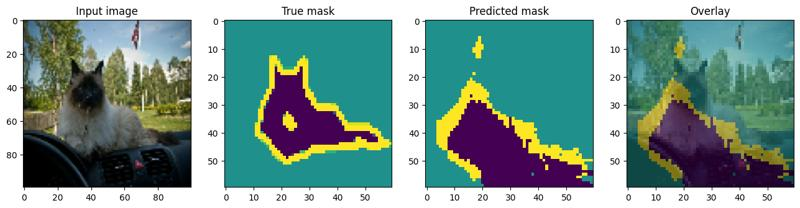

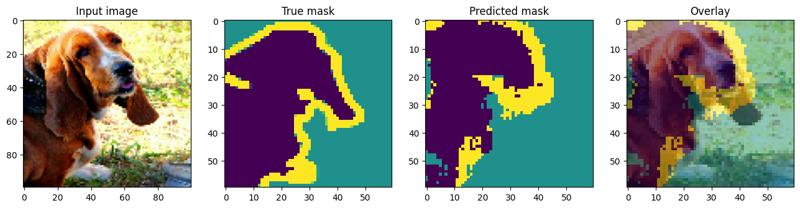

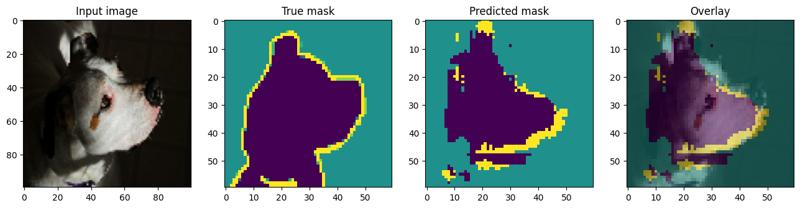

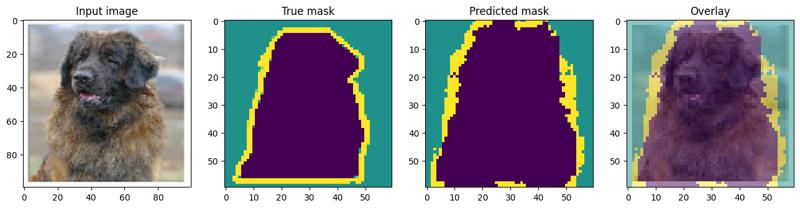

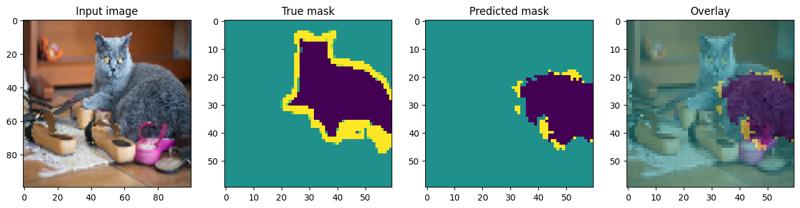

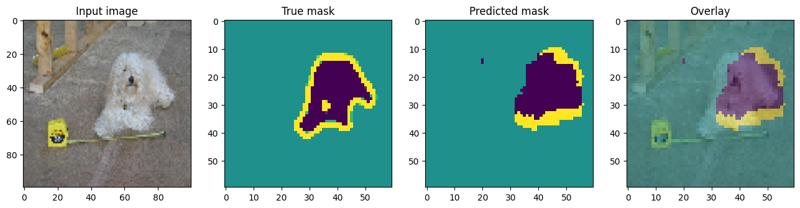

In [ ]:
for images, masks in test_batches.take(1):
  # Generate prediction for each image
  predicted_masks = model.predict(images)

  # Plot each image and masks in batch
  for index, (image, mask) in enumerate(zip(images, masks)):
    generate_plot(image, mask, predicted_masks[index])
    if index > 4:
      break